# Topic Modelling

In this notebook we'll take a look at the main themes and topics of todays top hits

### Imports & Setup

In [20]:
# data
import pandas as pd

# nlp
import re
import spacy
import contractions
import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora, models

# visualization
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# calculations
import numpy as np
from math import log
from collections import Counter


nlp = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_excel("../data/processed/hot100_translated_filtered.xlsx")

## Preprocessing

Before modeling, we need to prepare our text:
1. Cleaning: lowercase, remove punctuation and stop-words.
2. Tokenization: split into words.
3. Stemming/Lemmatization: reduce words to their root forms.

In [3]:
sounds = ["woah", "ah", "oh", "ahah", "ohoh", "oohwoah", "ooh", "dingdongde",
          "dingdongding", "wow", "hey", "yeah", "ey", "ik", "eah", "uh", "huh",
         "nah", "hell nah", "uhhuh", "la", "lalala", "lalalalalalalalala", "ayy",
         "ho", "ha", "oohooh", "irl", "er", "ou", "ya", "blah", "uhuh", "hol", "ll",
         "lala", "da", "dada", "okay", "etro", "oung", "gon", "bout", "uhuhuh", "baow",
         "het", "niet", "dadada", "giddy", "dadadada", "je", "lalalala", "ohohoh", "til"]

bigrams = {
    "jingle bell": "jingle_bell"
}

def clean(text):
    text = contractions.fix(text)    
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', " ", text).strip()

    return text

plurals = {
    "niggas": "nigga",
    "bitches": "bitch", 
    "hoes": "hoe"
}

def lemmatize(text):
    for p in plurals.keys():
        text = text.replace(p, plurals[p])    # Tackling profanity plurals
                
    doc = nlp(text)    # tokenizing    
    lemmas = [tok.lemma_ for tok in doc if not (tok.is_stop or tok.text in sounds)]    # dropping stop words and lemmatizing
    
    for bi in bigrams.keys():
        if bi in lemmas:
            lemmas.remove(bi)
            lemmas.append(bigrams[bi])

    return lemmas

def preprocess(text):
    return lemmatize(clean(text))

In [4]:
df["lyrics_clean"] = df["lyrics_en"].apply(preprocess)

In [5]:
df.head()

,date,rank,title,artist,image,peakPos,lastpos,weeks,isNew,song_id,lyrics,orig_lang,lyrics_en,lyrics_clean
0,2024-12-28,1,All I Want For Christmas Is You,Mariah Carey,https://charts-static.billboard.com/img/1994/1...,1,1,70,False,all_i_want_for_christmas_is_you__mariah_carey,i don't want a lot for christmas there is just...,en,i don't want a lot for christmas there is just...,"[want, lot, christmas, thing, need, care, pres..."
1,2024-12-28,2,Rockin' Around The Christmas Tree,Brenda Lee,https://charts-static.billboard.com/img/1960/1...,1,2,63,False,rockin_around_the_christmas_tree__brenda_lee,rockin' around the christmas tree at the chris...,en,rockin' around the christmas tree at the chris...,"[rockin, christmas, tree, christmas, party, ho..."
2,2024-12-28,3,Last Christmas,Wham!,https://charts-static.billboard.com/img/1998/0...,3,4,44,False,last_christmas__wham,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...",en,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...","[christmas, give, heart, day, give, away, year..."
3,2024-12-28,4,Jingle Bell Rock,Bobby Helms,https://charts-static.billboard.com/img/1958/1...,3,3,60,False,jingle_bell_rock__bobby_helms,"jingle bell, jingle bell, jingle bell rock jin...",en,"jingle bell, jingle bell, jingle bell rock jin...","[jingle, bell, jingle, bell, jingle, bell, roc..."
4,2024-12-28,5,A Holly Jolly Christmas,Burl Ives,https://charts-static.billboard.com/img/1998/0...,4,5,44,False,a_holly_jolly_christmas__burl_ives,ding-dong-ding ding-dong-ding have a holly jol...,en,ding-dong-ding ding-dong-ding have a holly jol...,"[holly, jolly, christmas, good, time, year, kn..."


## TF-IDF

We'll vectorize the data using sklearn.

- TF shows how common a token (or n-gram) is in a single document (song).
- IDF shows how rare a token (or n-gram) is within the entire corpus (chart).

So a high TF–IDF score means “this term shows up a lot in this song, but doesn’t show up much elsewhere”—making it a good thematic indicator for that song.

We can use the TF-IDF to have a better bag-of-words, therefore better classification.

In [6]:
# Build the initial dictionary & BoW corpus
dictionary = corpora.Dictionary(df['lyrics_clean'])
bow_corpus = [dictionary.doc2bow(text) for text in df['lyrics_clean']]

In [7]:
# Fit TF–IDF on the BoW
tfidf = models.TfidfModel(bow_corpus, dictionary=dictionary)

In [8]:
# Example: see the 5 lowest-IDF (too common) and 5 highest-IDF (too rare) tokens
sorted_idfs = sorted(tfidf.idfs.items(), key=lambda x: x[1])
print("Too-common tokens:", [(dictionary[id], idf) for id,idf in sorted_idfs[:5]])
print("Too-rare tokens:",   [(dictionary[id], idf) for id,idf in sorted_idfs[-5:]])

Too-common tokens: [('know', 0.48116708834885563), ('like', 0.48116708834885563), ('want', 0.7709744863311051), ('get', 0.8214823880416352), ('love', 1.023458972823989)]
Too-rare tokens: [('conspire', 9.539158811108031), ('unafraid', 9.539158811108031), ('kiddy', 9.539158811108031), ('chilling', 9.539158811108031), ('frolic', 9.539158811108031)]


In [9]:
# Filter extremes by IDF thresholds
low_idf, high_idf = 1.2, 8
bad_ids = [termid for termid, idf_val in tfidf.idfs.items()
           if idf_val < low_idf or idf_val > high_idf]

dictionary.filter_tokens(bad_ids)  # remove
dictionary.compactify()            # reindex remaining IDs

In [10]:
print(f"Filtered vocab size: {len(dictionary)}")

Filtered vocab size: 3270


In [12]:
# Rebuild filtered BoW corpus
bow_filtered = [dictionary.doc2bow(text) for text in df['lyrics_clean']]

## LDA

Creating an LDA to classify main topics after filtering common words, so they won't corrupt classification.

In [14]:
# Choosing the right k value with coherence checking
def compute_coherence_values(texts, dictionary, bow_corpus, k_list):
    coherences = []
    for k in k_list:
        model = gensim.models.LdaModel(
            corpus=bow_corpus,
            id2word=dictionary,
            num_topics=k,
            passes=10,
            random_state=42
        )
        cm = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherences.append(cm.get_coherence())
    return coherences

k_list = list(range(3,9))
coh_vals = compute_coherence_values(df['lyrics_clean'], dictionary, bow_filtered, k_list)

for k, cv in zip(k_list, coh_vals):
    print(f"K={k:>2} → Coherence = {cv:.4f}")


K= 3 → Coherence = 0.2938
K= 4 → Coherence = 0.2864
K= 5 → Coherence = 0.2832
K= 6 → Coherence = 0.2720
K= 7 → Coherence = 0.2839
K= 8 → Coherence = 0.2962


We can see that k=3, k=8 output the best values, so we'll try both.

After testing both, k=3 results in loss of key topics as they merge under the same "bucket".

In [17]:
# Train LDA on filtered counts
num_topics = 8
lda = LdaModel(
    corpus=bow_filtered,
    id2word=dictionary,
    num_topics=num_topics,
    passes=15,
    random_state=42
)

In [18]:
# Inspect topics
for idx, topic in lda.show_topics(formatted=False):
    print(f"Topic {idx}: {[w for w,_ in topic]}")

Topic 0: ['christmas', 'dance', 'come', 'year', 'night', 'bell', 'jingle', 'thing', 'think', 'santa']
Topic 1: ['feel', 'leave', 'need', 'way', 'time', 'come', 'good', 'night', 'say', 'let']
Topic 2: ['think', 'life', 'find', 'time', 'lose', 'need', 'come', 'hate', 'feel', 'face']
Topic 3: ['let', 'time', 'baby', 'feel', 'come', 'look', 'life', 'wait', 'night', 'right']
Topic 4: ['ride', 'stop', 'talk', 'look', 'bae', 'let', 'stick', 'good', 'well', 'kiss']
Topic 5: ['nigga', 'fuck', 'shit', 'bitch', 'hit', 'let', 'right', 'hoe', 'come', 'baby']
Topic 6: ['bitch', 'shit', 'come', 'look', 'black', 'money', 'talk', 'baby', 'nigga', 'fuck']
Topic 7: ['girl', 'baby', 'bitch', 'good', 'bad', 'say', 'man', 'right', 'think', 'let']


In [19]:
# 2. Enable notebook output
pyLDAvis.enable_notebook()

# 3. Prepare the visualization
vis_data = gensimvis.prepare(lda, bow_filtered, dictionary)

# 4. Display inline
vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.116679  0.056264       1        1  23.177683
3      0.061513  0.001933       2        1  22.214035
1      0.030726  0.014635       3        1  11.667249
2      0.044335  0.037203       4        1  11.188069
7     -0.050129  0.031877       5        1  10.669962
6     -0.116923  0.038192       6        1   8.743771
0      0.187467  0.013831       7        1   8.111346
4     -0.040309 -0.193935       8        1   4.227885, topic_info=          Term         Freq        Total Category  logprob  loglift
505      nigga  1170.000000  1170.000000  Default  30.0000  30.0000
267      bitch   979.000000   979.000000  Default  29.0000  29.0000
348       girl   594.000000   594.000000  Default  28.0000  28.0000
7    christmas   198.000000   198.000000  Default  27.0000  27.0000
424       ride   228.000000   228.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
559       body    18.377640   187.585231   Topic8  -5.3078   0.8404
283       fuck    22.075138   900.110423   Topic8  -5.1245  -0.5446
52        wait    18.142669   252.525754   Topic8  -5.3207   0.5302
348       girl    19.335339   594.972284   Topic8  -5.2570  -0.2631
291       life    18.853138   481.194654   Topic8  -5.2823  -0.0761

[624 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
773       1  0.186171         2
773       3  0.124114         2
773       5  0.682626         2
2887      1  0.852584        50
3264      1  0.068360       aby
...     ...       ...       ...
331       5  0.029499     young
331       6  0.309742     young
331       7  0.081123     young
331       8  0.044249     young
387       7  0.908385  yuletide

[1841 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 3, 8, 7, 1, 5])

### Assigning labels to each topic (or topic group)

In [21]:
topic_to_group = {
    0: 'Holiday',
    1: 'Feelings & Longing',
    2: 'Feelings & Longing',
    3: 'Feelings & Longing',
    4: 'Romance & Hook-Ups',
    5: 'Hard-Core/Rap',
    6: 'Hard-Core/Rap',
    7: 'Romance & Hook-Ups'
}

In [22]:
# Get each song’s document-topic distribution
doc_topics = [
    lda.get_document_topics(bow, minimum_probability=0.0)
    for bow in bow_filtered
]

In [33]:
# 3. For each song, pick the single dominant topic
dominant_topics = [
    max(dist, key=lambda pair: pair[1])[0]
    for dist in doc_topics
]

In [34]:
# Map each dominant topic to its label
dominant_groups = [topic_to_group[t] for t in dominant_topics]

In [40]:
# Count how many songs fall into each topic
group_counts = Counter(dominant_groups)
groups, counts = zip(*group_counts.items())

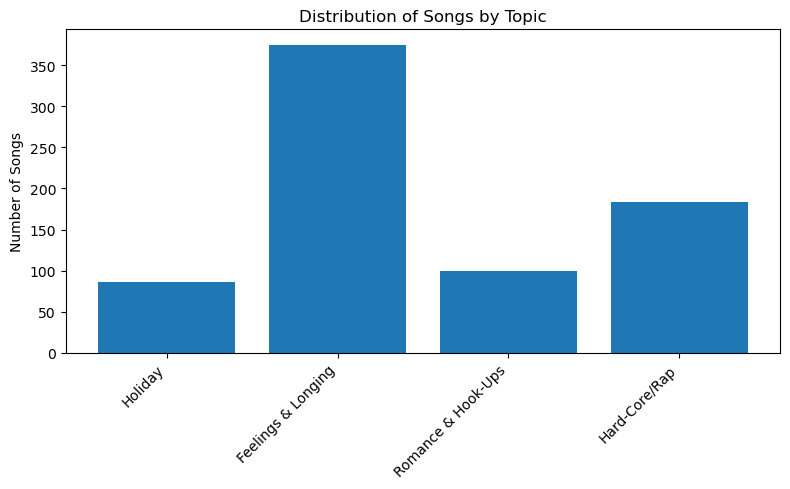

In [41]:
# 6. Plot a simple bar chart
plt.figure(figsize=(8, 5))
plt.bar(groups, counts)
plt.title('Distribution of Songs by Topic')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Showcasing some songs

Build a DataFrame of topic probabilities

In [133]:
num_topics = len(topic_cols)
labels = list(dict.fromkeys(topic_to_group.values()))


rows = []
for title, artist, dist in zip(df['title'], df['artist'], doc_topics):
        # sum up probabilities per meta-topic
    group_probs = {label: 0.0 for label in labels}
    for tid, p in dist:
        label = topic_to_group[tid]
        group_probs[label] += p
    row = {'title': title, 'artist': artist, **group_probs}
    rows.append(row)
df_dist = pd.DataFrame(rows).fillna(0)

In [132]:
df_dist

,title,artist,Holiday,Feelings & Longing,Romance & Hook-Ups,Hard-Core/Rap
0,All I Want For Christmas Is You,Mariah Carey,0.823642,0.115763,0.019804,0.040791
1,Rockin' Around The Christmas Tree,Brenda Lee,0.985154,0.006363,0.004242,0.004241
2,Last Christmas,Wham!,0.616746,0.379573,0.001841,0.001840
3,Jingle Bell Rock,Bobby Helms,0.991330,0.003716,0.002477,0.002477
4,A Holly Jolly Christmas,Burl Ives,0.885774,0.105871,0.004179,0.004176
...,...,...,...,...,...,...
739,I Saw Mommy Kissing Santa Claus,Jackson 5,0.304575,0.359929,0.332246,0.003250
740,Merry Christmas,Ed Sheeran & Elton John,0.860264,0.135268,0.002235,0.002234
741,(There's No Place Like) Home For The Holidays ...,Perry Como With Mitchell Ayers And His Orchestra,0.001566,0.992178,0.003128,0.003128
742,Winter Wonderland,Chloe,0.710534,0.281516,0.003975,0.003975


In [143]:
selected_titles = [
    "All I Want For Christmas Is You",
    "Last Christmas",
    "Espresso",
    "Lose Control",
    "Die With A Smile",
    "Too Sweet",
    "Not Like Us",
    "Houdini",
    "Yeah!"
]

Plotting

In [144]:
# Filter your dataframe (assumes it's named df_dist with a 'title' column)
examples = df_dist[df_dist['title'].isin(selected_titles)]

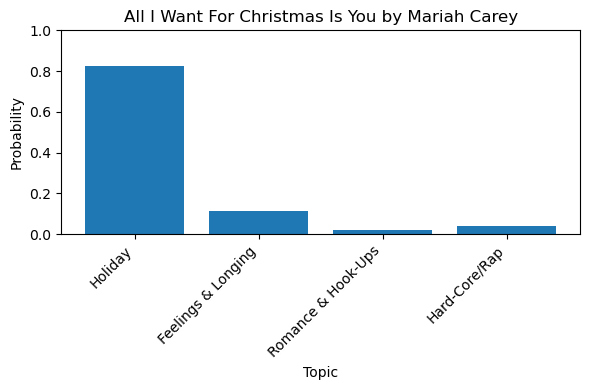

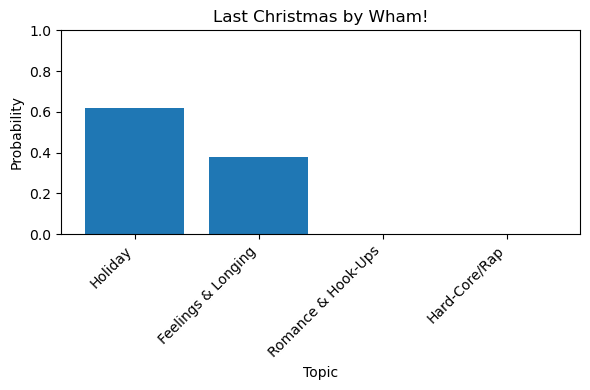

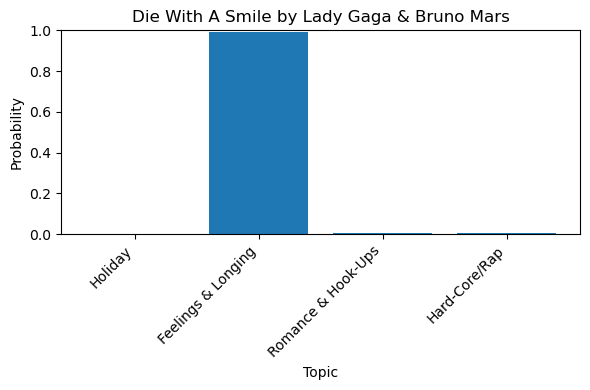

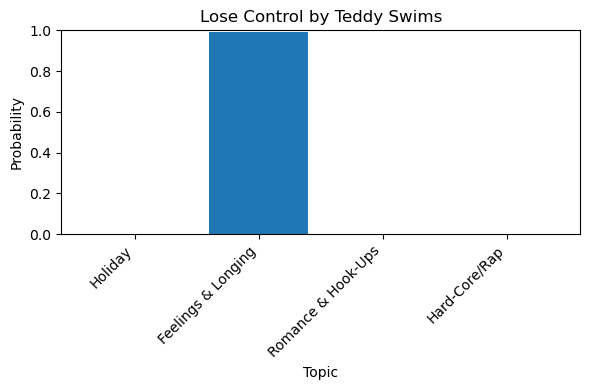

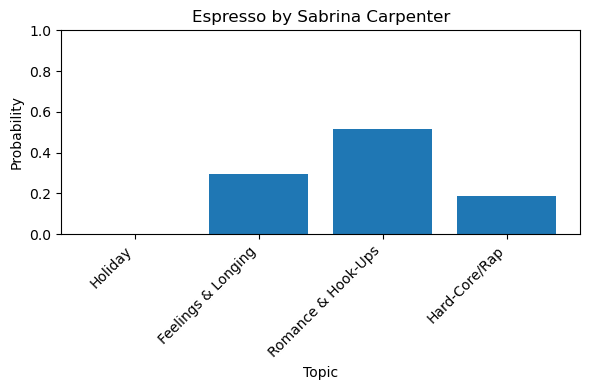

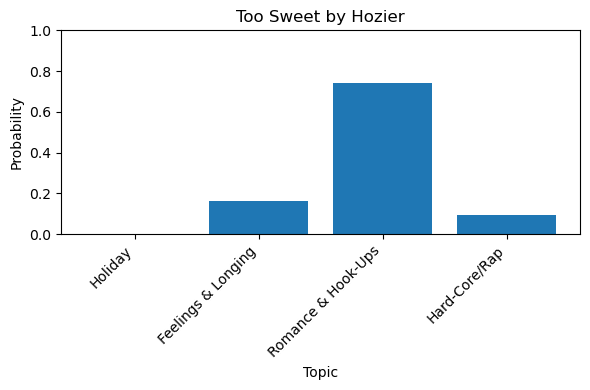

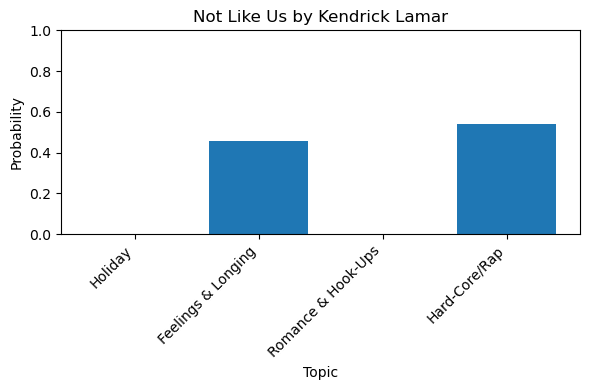

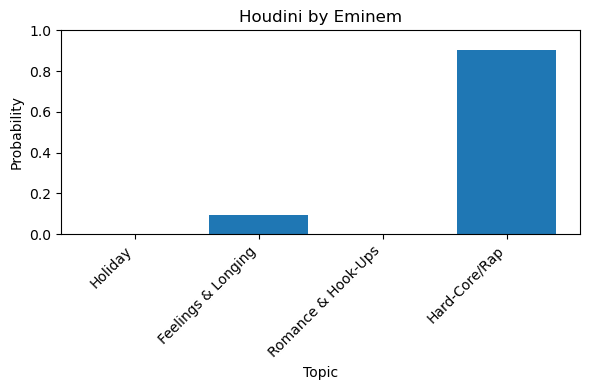

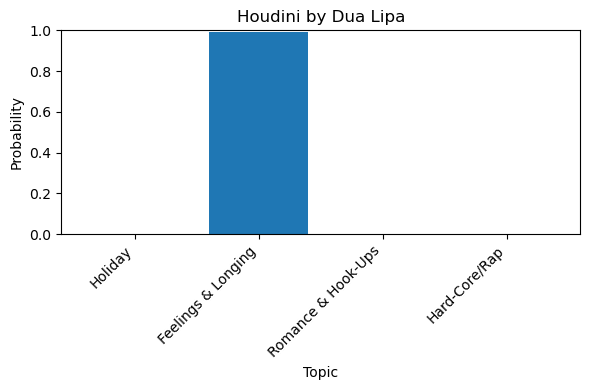

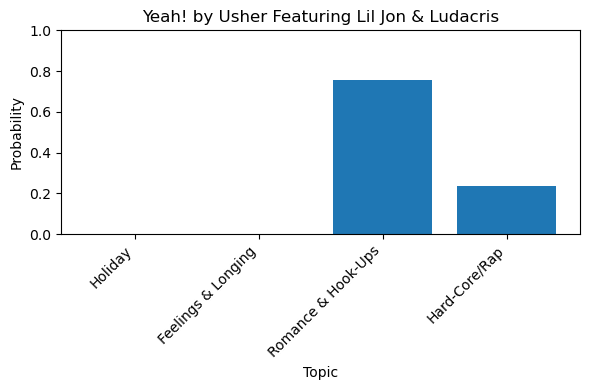

In [147]:
for _, row in examples.iterrows():   
    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(labels, row[labels].values)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{row["title"]} by {row["artist"]}')
    plt.xlabel('Topic')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()